In [1]:
# loading modules
import ee
import geemap
import time

# initialize ee 
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()


# import all FMSE py functions 
from FMSE import *


In [2]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [3]:
# get drawm layer from map
aoi = Map.draw_last_feature
aoi.getInfo()

AttributeError: 'NoneType' object has no attribute 'getInfo'

In [2]:
# CASE 1: Pakistan Floods 2022
# inputs
# Define the Area of Interest (aoi)

name = 'Pakistan_Floods_2022'
aoi = ee.Geometry.Polygon([[[67.571411, 26.280487],
    [67.571411, 26.587913],
    [68.083649, 26.587913],
    [68.083649, 26.280487],
    [67.571411, 26.280487]]])

#aoi = ee.Geometry.Polygon(
#    [[[67.98392410136336, 26.049909335428502],
#      [67.98392410136336, 25.42892423506662],
#      [68.59778518534773, 25.42892423506662],
#      [68.59778518534773, 26.049909335428502]]])

startDate = ee.Date('2022-03-01')
endDate = ee.Date('2022-08-20')
predays = 60
postdays = 20

# optional
split = 0.9
zvv_value = -3
zvh_value = -3
water_value = 75
elev_value = 800
slope_value = 10
num_samples = 200
under_estimate = False



## Flood layer Masking

In [3]:
# Fetching pre and post-flood images
s1_pre = get_s1_col(startDate, predays, aoi).select(['VV', 'VH'])
s1_post = get_s1_col(endDate, postdays, aoi).select(['VV', 'VH'])

print('Images in S1 Pre: ', s1_pre.size().getInfo())
print('Images in S1 Post: ', s1_post.size().getInfo())

# Calculate Z-score
zscore = calculate_zscore(s1_pre, s1_post, aoi)

# Generate flood masks
flood_class, flood_layer = map_floods(zscore, aoi, zvv_value, zvh_value, water_value, elev_value, slope_value, under_estimate)

print('Done with flood masking...')

Images in S1 Pre:  20
Images in S1 Post:  6
Done with flood masking...


In [4]:
# Run flood mapping example
flood_binary = flood_mapping(aoi, s1_post, flood_layer, num_samples, split)
print('Done with flood mapping...')

Done with preparing datasets...
Done with creating sample feature collection...
Done with creating training and validation samples...
Done with classification...
Training Accuracy Metrics:
Overall Accuracy: 0.9752066115702479
Kappa: 0.950375939849624
Producer's Accuracy: [[0.9772727272727273], [0.9732620320855615]]
User's Accuracy: [[0.9717514124293786, 0.978494623655914]]
F1 Score: 0.9758713136729223
Validation Accuracy Metrics:
Overall Accuracy: 0.8108108108108109
Kappa: 0.5774877650897228
Producer's Accuracy: [[0.875], [0.6923076923076923]]
User's Accuracy: [[0.84, 0.75]]
F1 Score: 0.7199999999999999
Done with accuracy metrics...
Done with flood mapping...


In [5]:
# Run susceptibility analysis example
flood_susceptibility_prob = susceptibility_analysis(aoi, endDate, flood_binary, num_samples, split)
print('Done with susceptibility analysis...')

Done with preparing datasets for susceptibility analysis...
Size of label collection: 400
Bands for susceptibility analysis: ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'NDVI', 'NDWI', 'NDBI', 'NDSI', 'elevation', 'slope', 'aspect']
Training sus first:  {'type': 'Feature', 'geometry': None, 'id': '0_0', 'properties': {'NDBI': -0.22544051706790924, 'NDSI': -0.6944701075553894, 'NDVI': 0.5822446346282959, 'NDWI': -0.5422855615615845, 'SR_B1': 0.03908500000000001, 'SR_B2': 0.047087500000000004, 'SR_B3': 0.07750249999999997, 'SR_B4': 0.06895000000000001, 'SR_B5': 0.26114750000000003, 'SR_B6': 0.1650625, 'SR_B7': 0.0962575, 'aspect': 243.4364013671875, 'elevation': 37.40999984741211, 'label': 1, 'random': 0.6181016947252327, 'slope': 0.07171349227428436}}
Validation F1 Score: 0.6923076923076923
Validation Producer Accuracy: [0.6923076923076923]
Validation Consumer Accuracy: None
Done with susceptibility analysis...


In [6]:
def quantile_based_categorization(susceptibility_layer, aoi):
    """
    Convert a continuous flood susceptibility layer into five categorical classes based on quantiles.

    Parameters:
    susceptibility_layer (ee.Image): Continuous flood susceptibility layer with values between 0 and 1.
    aoi (ee.Geometry): Area of Interest for calculating quantiles.

    Returns:
    ee.Image: Categorical flood susceptibility layer with values from 1 to 5.
    """
    # Calculate quantiles for the susceptibility layer
    quantiles = susceptibility_layer.reduceRegion(
        reducer=ee.Reducer.percentile([20, 40, 60, 80], ['p20', 'p40', 'p60', 'p80']),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    )
    #print('Quantiles:', quantiles.getInfo())
    # Extract quantile values
    q20 = quantiles.get('classification_p20')
    q40 = quantiles.get('classification_p40')
    q60 = quantiles.get('classification_p60')
    q80 = quantiles.get('classification_p80')

    # Apply quantile thresholds to create categorical classes
    very_low = susceptibility_layer.lte(ee.Number(q20)).multiply(1)
    low = susceptibility_layer.gt(ee.Number(q20)).And(susceptibility_layer.lte(ee.Number(q40))).multiply(2)
    moderate = susceptibility_layer.gt(ee.Number(q40)).And(susceptibility_layer.lte(ee.Number(q60))).multiply(3)
    high = susceptibility_layer.gt(ee.Number(q60)).And(susceptibility_layer.lte(ee.Number(q80))).multiply(4)
    very_high = susceptibility_layer.gt(ee.Number(q80)).multiply(5)

    # Combine all classes into a single layer
    categorical_layer = very_low.add(low).add(moderate).add(high).add(very_high).rename('susceptibility')

    return categorical_layer

sus_catagory = quantile_based_categorization(flood_susceptibility_prob, aoi)


In [10]:
Map = geemap.Map()
Map.centerObject(aoi, 10)


Map.addLayer(flood_class, {'min': 0, 'max': 4, 'palette': ['#FFFFFF','#FFA500','#FFFF00','#FF0000','#0000FF']}, 'Flood class')# non-flooded, vv, vh, vv+vh, water
Map.addLayer(flood_layer, {'min': 1, 'max': 2, 'palette': ['blue', 'white']}, 'Flood layer')
Map.addLayer(flood_binary, {'min': 1, 'max': 2, 'palette': ['blue', 'white']}, 'Flood Binary')
Map.addLayer(flood_susceptibility_prob, {'min': 0.1, 'max': 0.9, 'palette': ['#2c7bb6', '#abd9e9', '#ffffbf', '#fdae61', '#d7191c']}, 'Flood Susceptibility')

Map.addLayer(sus_catagory, {'min': 1, 'max': 5, 'palette': ['#2c7bb6', '#abd9e9', '#ffffbf', '#fdae61', '#d7191c']}, 'Flood Susceptibility Categorical')
Map

Map(center=[26.43435984960125, 67.82752999999994], controls=(WidgetControl(options=['position', 'transparent_b…

# Exposure Analysis

## Population Exposed to Floods

Total population: 521432
Total population exposed to flood: 180683


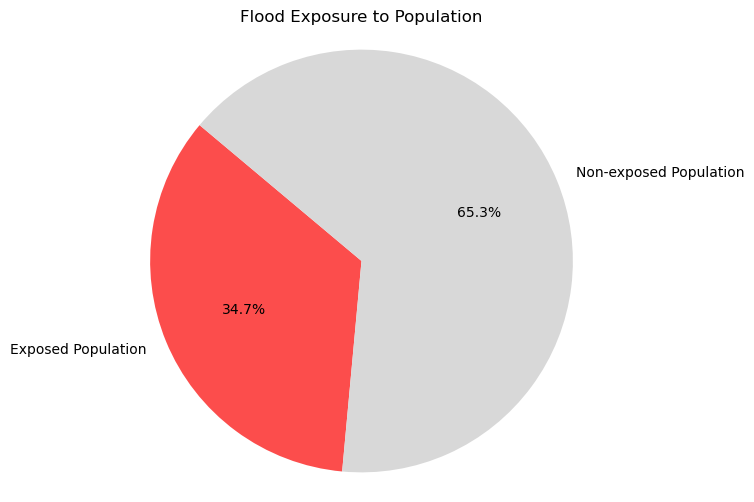

In [7]:

import matplotlib.pyplot as plt


def calculate_flood_exposure(flood_binary, aoi):
    """
    Calculate the population exposed to the flood based on the flood layer.

    Parameters:
    flood_layer (ee.Image): Flood layer with values 1 for flooded and 2 for non-flooded.
    population_dataset (str): Path to the population dataset.
    aoi (ee.Geometry): Area of Interest.

    Returns:
    ee.Number: Total population exposed to the flood.
    """
    # Load population dataset
    population = ee.ImageCollection('WorldPop/GP/100m/pop')\
                    .filter(ee.Filter.eq('year', 2020))\
                    .mosaic()\
                    .clip(aoi)
    
    # Mask non-flooded areas
    flood_exposure = population.updateMask(flood_binary.eq(1))
    
    # Calculate total exposed population
    total_exposed_population = flood_exposure.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=90,
        maxPixels=1e12
    ).get('population')
    
     # Calculate total population in the study area
    total_population = population.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=90,
        maxPixels=1e12
    ).get('population')
    
    return total_exposed_population, total_population

def visualize_flood_exposure(total_exposed_population, total_population):
    
    """
    Visualize flood exposure as a pie chart.

    Parameters:
    total_exposed_population (ee.Number): Total population exposed to the flood.
    total_population (ee.Number): Total population in the study area.
    """
    exposed_population = total_exposed_population.getInfo()
    total_pop = total_population.getInfo()
    non_exposed_population = total_pop - exposed_population
    
    labels = ['Exposed Population', 'Non-exposed Population']
    sizes = [exposed_population, non_exposed_population]
    colors = ['#fc4d4c', '#d8d8d8']  # Tomato color for exposed population, light green for non-exposed population
    
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title('Flood Exposure to Population')
    plt.show()

total_exposed_population, total_population = calculate_flood_exposure(flood_binary, aoi)

# print total population without decimal points
print('Total population:', int(total_population.getInfo()))
print('Total population exposed to flood:', int(total_exposed_population.getInfo()))

visualize_flood_exposure(total_exposed_population, total_population)


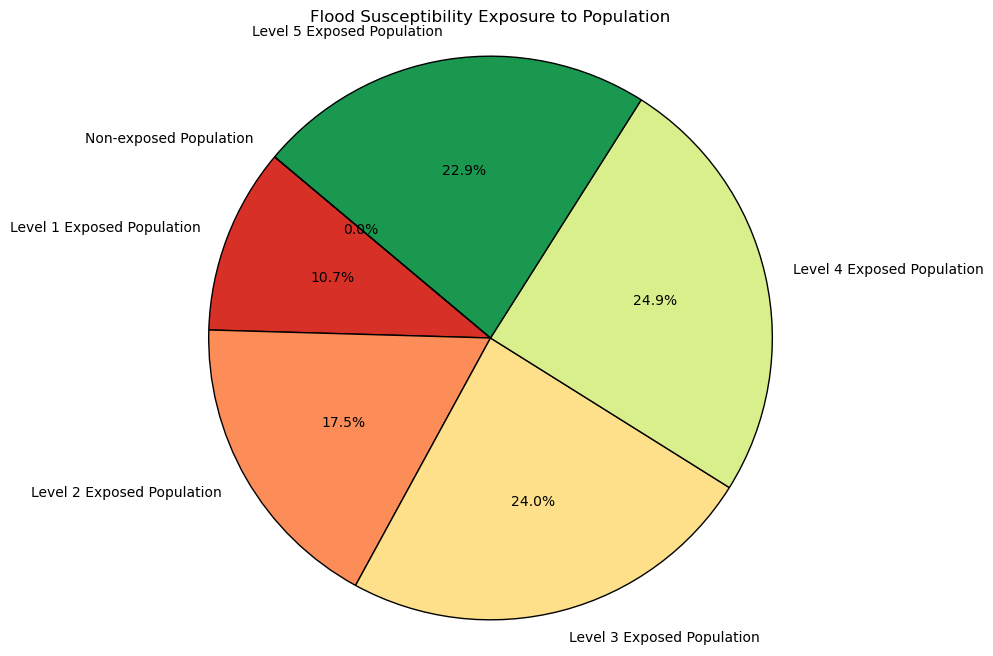

In [12]:


def calculate_susceptibility_exposure(susceptibility_layer, aoi, num_classes=5):
    """
    Calculate the population exposed to different flood susceptibility levels.

    Parameters:
    susceptibility_layer (ee.Image): Categorical flood susceptibility layer with values from 1 to 5.
    population_dataset (str): Path to the population dataset.
    aoi (ee.Geometry): Area of Interest.

    Returns:
    dict: Dictionary with susceptibility levels as keys and exposed population as values.
    """
    # Load population dataset
    population = ee.ImageCollection('WorldPop/GP/100m/pop')\
                    .filter(ee.Filter.eq('year', 2020))\
                    .mosaic()\
                    .clip(aoi)
    
    # Dictionary to hold results
    exposure_results = {}

    # Calculate exposure for each susceptibility level
    for level in range(1, num_classes + 1):
        # Mask areas that do not match the current susceptibility level
        level_exposure = population.updateMask(susceptibility_layer.eq(level))
        
        # Calculate total exposed population for the current level
        exposed_population = level_exposure.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=aoi,
            scale=30,
            maxPixels=1e12
        ).get('population')
        
        exposure_results[level] = exposed_population
    
    return exposure_results

def visualize_susceptibility_exposure(exposure_results, total_population):
    total_pop = total_population.getInfo()
    labels = []
    sizes = []
    colors = ['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#1a9850']
    
    for level, exposure in exposure_results.items():
        exposed_population = exposure.getInfo()
        if exposed_population < 0:
            exposed_population = 0
        labels.append(f'Level {level} Exposed Population')
        sizes.append(exposed_population)
    
    non_exposed_population = total_pop - sum(sizes)
    if non_exposed_population < 0:
        non_exposed_population = 0
    labels.append('Non-exposed Population')
    sizes.append(non_exposed_population)
    colors.append('#999999')
    
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'black'})
    plt.axis('equal')
    plt.title('Flood Susceptibility Exposure to Population')
    plt.show()




# Calculate exposure
susceptibility_exposure = calculate_susceptibility_exposure(sus_catagory, aoi)

#print('Population exposed to each susceptibility level:', {level: exposure.getInfo() for level, exposure in susceptibility_exposure.items()})

# Visualize exposure
visualize_susceptibility_exposure(susceptibility_exposure, total_population)


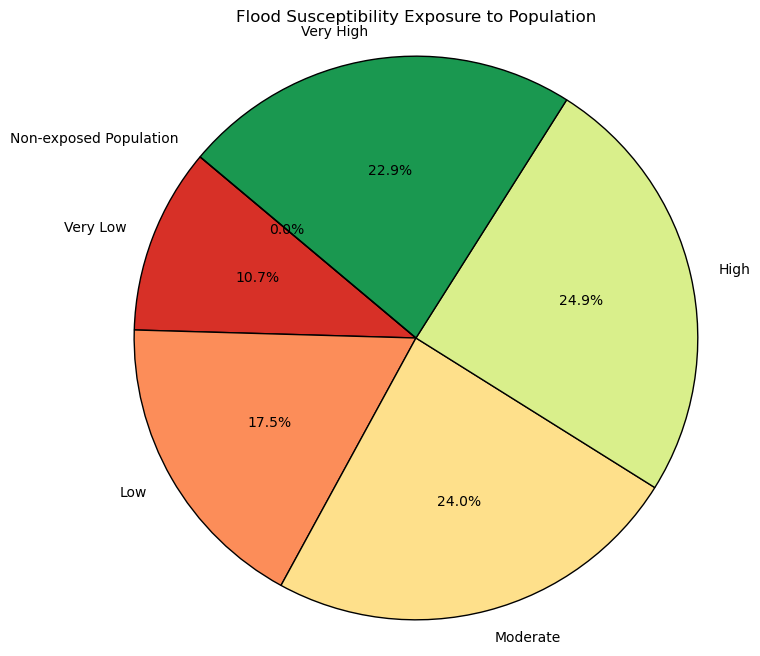

In [15]:

def visualize_susceptibility_exposure(exposure_results, total_population):
    """
    Visualize susceptibility exposure as a pie chart.

    Parameters:
    exposure_results (dict): Dictionary with susceptibility levels as keys and exposed population as values.
    total_population (ee.Number): Total population in the study area.
    """
    total_pop = total_population.getInfo()
    labels = ["Very Low", "Low", "Moderate", "High", "Very High"]
    sizes = []
    colors = ['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#1a9850']
    
    for level in range(1, 6):
        exposed_population = exposure_results[level].getInfo()
        if exposed_population < 0:
            exposed_population = 0
        sizes.append(exposed_population)
    
    non_exposed_population = total_pop - sum(sizes)
    if non_exposed_population < 0:
        non_exposed_population = 0
    
    sizes.append(non_exposed_population)
    labels.append('Non-exposed Population')
    colors.append('#999999')
    
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'black'})
    plt.axis('equal')
    plt.title('Flood Susceptibility Exposure to Population')
    plt.show()


# Visualize exposure
visualize_susceptibility_exposure(susceptibility_exposure, total_population)


In [14]:
print('Population exposed to each susceptibility level:', {level: exposure.getInfo() for level, exposure in susceptibility_exposure.items()})


Population exposed to each susceptibility level: {1: 499363.2399202734, 2: 820293.5424267054, 3: 1126554.2634163946, 4: 1167971.3347939253, 5: 1071498.277828455}


In [8]:
import pandas as pd
def calculate_exposure_df(susceptibility_layer, aoi, flood_map=False):
    """
    Calculate exposure for population, nighttime light, and land cover for each susceptibility level or flood map.

    Parameters:
    susceptibility_layer (ee.Image): Flood susceptibility layer or flood map.
    population_dataset (str): Path to the population dataset.
    nightlight_dataset (str): Path to the nighttime light dataset.
    landcover_dataset (str): Path to the land cover dataset.
    aoi (ee.Geometry): Area of Interest.
    flood_map (bool): Flag to indicate if susceptibility categories or flood map should be used.

    Returns:
    pd.DataFrame: Dataframe with exposure information.
    """
        # Define remap function for landcover
    def remapper(image):
        return image.remap([1, 2, 4, 5, 7, 8, 9, 10, 11], [1, 2, 3, 4, 5, 6, 7, 8, 9])

    # Load datasets
    population = ee.ImageCollection('WorldPop/GP/100m/pop')\
                    .filter(ee.Filter.eq('year', 2020))\
                    .mosaic()\
                    .clip(aoi).rename('b1')
    nightlight = ee.Image('projects/sat-io/open-datasets/npp-viirs-ntl/LongNTL_2022').clip(aoi).rename('b1')
    landcover = ee.ImageCollection('projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m_TS')\
                    .filterDate('2022-01-01', '2022-12-31')\
                    .map(remapper)\
                    .mosaic().clip(aoi).rename('b1')
    

    # Initialize results dictionary with descriptive land cover names
    results = {
        'Susceptibility Level': [],
        'Exposed Population': [],
        'Exposed Nighttime Light': [],
        'lulc_water': [],
        'lulc_trees': [],
        'lulc_flooded_vegetation': [],
        'lulc_crops': [],
        'lulc_built_area': [],
        'lulc_bare_ground': [],
        'lulc_snow_ice': [],
        'lulc_clouds': [],
        'lulc_rangeland': [],
        'Category': []
    }
    
    if flood_map:
        susceptibility_levels = [1]
        susceptibility_layer = susceptibility_layer.gt(0).selfMask()
        category_names = ['Flooded']
    else:
        # Define quantile-based categories
        susceptibility_levels = range(1, 6)
        category_names = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
    
    # Calculate exposure for each susceptibility level
    for level, category in zip(susceptibility_levels, category_names):
        # Mask areas that do not match the current susceptibility level
        level_mask = susceptibility_layer.eq(level)
        level_population = population.updateMask(level_mask)
        level_nightlight = nightlight.updateMask(level_mask)
        level_landcover = landcover.updateMask(level_mask)

        # Calculate total exposed population
        exposed_population = level_population.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=aoi,
            scale=30,
            maxPixels=1e12
        ).get('b1').getInfo()

        # Calculate total exposed nighttime light
        exposed_nightlight = level_nightlight.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=aoi,
            scale=30,
            maxPixels=1e12
        ).get('b1').getInfo()

        # Calculate land cover area for each class
        landcover_areas = level_landcover.reduceRegion(
            reducer=ee.Reducer.frequencyHistogram(),
            geometry=aoi,
            scale=30,
            maxPixels=1e12
        ).get('b1').getInfo()

        # Append results to the dictionary
        results['Susceptibility Level'].append(level)
        results['Exposed Population'].append(exposed_population)
        results['Exposed Nighttime Light'].append(exposed_nightlight)
        landcover_classes = {
            'lulc_water': 1,
            'lulc_trees': 2,
            'lulc_flooded_vegetation': 3,
            'lulc_crops': 4,
            'lulc_built_area': 5,
            'lulc_bare_ground': 6,
            'lulc_snow_ice': 7,
            'lulc_clouds': 8,
            'lulc_rangeland': 9
        }
        for lulc_name, lulc_code in landcover_classes.items():
            results[lulc_name].append(landcover_areas.get(str(lulc_code), 0))
        results['Category'].append(category)
    
    # Convert results to dataframe
    df = pd.DataFrame(results)
    return df


# Calculate exposure dataframe
exposure_df = calculate_exposure_df(sus_catagory, aoi, flood_map=False)
print(exposure_df)


   Susceptibility Level  Exposed Population  Exposed Nighttime Light  \
0                     1        4.993632e+05             39002.369997   
1                     2        8.202935e+05             61152.084767   
2                     3        1.126554e+06             97198.499573   
3                     4        1.167971e+06            120368.394460   
4                     5        1.071498e+06             94470.359780   

   lulc_water  lulc_trees  lulc_flooded_vegetation  lulc_crops  \
0      187370         138                       96      154783   
1       47218        1028                     2506      199706   
2       33783         348                     1173      243534   
3       37807          14                       32      255187   
4       23479           0                        0      245001   

   lulc_built_area  lulc_bare_ground  lulc_snow_ice  lulc_clouds  \
0             7488              3054              0            0   
1            12318             272

In [9]:
# save df as csv

exposure_df.to_csv('exposure_df.csv', index=False)

In [ ]:
flood_layer_task = ee.batch.Export.image.toDrive(
    image=flood_binary,
    description='flood_layer',
    folder='earth_engine_exports',
    scale=10,
    region=aoi,
    maxPixels=1e13
)
flood_layer_task.start()
# Export susceptibility layer
susceptibility_task = ee.batch.Export.image.toDrive(
    image=flood_prob,
    description='flood_susceptibility_layer',
    folder='earth_engine_exports',
    scale=30,
    region=aoi,
    maxPixels=1e13

In [ ]:
# test code to compare models

# Parameters
num_samples = 1000  # Number of sample points
split = 0.8  # Train-test split ratio
bands = ['VV', 'VH']  # Bands to use for classification

# Create the 'sample' feature collection
sample = flood_layer.stratifiedSample(
    numPoints=num_samples,
    classBand='label',
    region=aoi,
    scale=10,
    seed=5,
    tileScale=1.5,
    geometries=True
)

# Update label values: change non-flood (label 2) to 0
def updateFeature(feature):
    value = feature.get('label')
    updated_value = ee.Algorithms.If(ee.Algorithms.IsEqual(value, ee.Number(2)), ee.Number(0), value)
    return feature.set('label', updated_value)

label = sample.map(updateFeature)

# Verify label values
unique_labels = label.aggregate_array('label').distinct().getInfo()
print(f"Unique labels: {unique_labels}")

# Prepare image for classification
image = s1_post.mean().clip(aoi)

# Create training and validation samples
sample_all = image.select(bands).sampleRegions(
    collection=label,
    properties=['label'],
    scale=10
).randomColumn()

training = sample_all.filter(ee.Filter.lt('random', split))
validation = sample_all.filter(ee.Filter.gte('random', split))

# Define classifiers to compare
classifiers = {
    'RandomForest': ee.Classifier.smileRandomForest(115),
    'GradientTreeBoost': ee.Classifier.smileGradientTreeBoost(100),
    'DecisionTree': ee.Classifier.smileCart(),
    #'NaiveBayes': ee.Classifier.smileNaiveBayes(),
    'SVM': ee.Classifier.libsvm()
}

def evaluate_classifier(classifier, training, validation):
    start_time = time.time()
    
    trained_classifier = classifier.train(
        features=training,
        classProperty='label',
        inputProperties=bands
    )
    
    training_classified = training.classify(trained_classifier)
    validation_classified = validation.classify(trained_classifier)
    
    training_accuracy = training_classified.errorMatrix('label', 'classification')
    validation_accuracy = validation_classified.errorMatrix('label', 'classification')
    
    end_time = time.time()
    prediction_time = end_time - start_time
    
    return {
        'train_f1': training_accuracy.fscore().getInfo()[1] if len(training_accuracy.fscore().getInfo()) > 1 else None,
        'validation_f1': validation_accuracy.fscore().getInfo()[1] if len(validation_accuracy.fscore().getInfo()) > 1 else None,
        'train_producer_accuracy': training_accuracy.producersAccuracy().getInfo()[1] if len(training_accuracy.producersAccuracy().getInfo()) > 1 else None,
        'validation_producer_accuracy': validation_accuracy.producersAccuracy().getInfo()[1] if len(validation_accuracy.producersAccuracy().getInfo()) > 1 else None,
        'train_consumer_accuracy': training_accuracy.consumersAccuracy().getInfo()[1] if len(training_accuracy.consumersAccuracy().getInfo()) > 1 else None,
        'validation_consumer_accuracy': validation_accuracy.consumersAccuracy().getInfo()[1] if len(validation_accuracy.consumersAccuracy().getInfo()) > 1 else None,
        'prediction_time': prediction_time
    }

# Evaluate all classifiers
results = {}
for name, classifier in classifiers.items():
    print(f"Evaluating {name} classifier...")
    results[name] = evaluate_classifier(classifier, training, validation)

# Print results
for name, metrics in results.items():
    print(f"\nClassifier: {name}")
    print(f"Training F1 Score: {metrics['train_f1']}")
    print(f"Validation F1 Score: {metrics['validation_f1']}")
    print(f"Training Producer Accuracy: {metrics['train_producer_accuracy']}")
    print(f"Validation Producer Accuracy: {metrics['validation_producer_accuracy']}")
    print(f"Training Consumer Accuracy: {metrics['train_consumer_accuracy']}")
    print(f"Validation Consumer Accuracy: {metrics['validation_consumer_accuracy']}")
    print(f"Prediction Time: {metrics['prediction_time']} seconds")

# Optionally, export the best classifier's results
# best_classifier_name = max(results, key=lambda k: results[k]['validation_f1'])
# best_classifier = classifiers[best_classifier_name].train(
#     features=training,
#     classProperty='label',
#     inputProperties=bands
# )
# classified_image = image.select(bands).classify(best_classifier)
# geemap.ee_export_image_to_drive(classified_image, description=f'best_classifier_{best_classifier_name}', folder='earth_engine', scale=10, region=aoi)


# Susceptibility

In [ ]:
# Variables Preparation for Susceptibility
# Variables used: DEM, Slope, Aspect, NDVI, NDWI, NDBI, NDSI

# Apply scaling factors to Landsat images
def applyScaleFactors(image):
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True)

# Year extraction from endDate
year = ee.Date(endDate).get('year')

# Filter Landsat 8 for 2013 to end of 2021
l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')\
        .filterBounds(aoi)\
        .filterDate('2013-01-01', '2021-11-01')

# Filter Landsat 9 for 2022 onwards
l9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')\
        .filterBounds(aoi)

# Combine both collections, prioritizing Landsat 9 for 2022
landsat_combined = l8.merge(l9)

# Filter the combined collection for the specified year
landsat_filtered = landsat_combined.filter(ee.Filter.calendarRange(year, year, 'year'))\
                                   .filter(ee.Filter.lt('CLOUD_COVER', 10))\
                                   .map(applyScaleFactors)\
                                   .median()\
                                   .clip(aoi)
proj = landsat_filtered.projection()
# Datasets
dem = ee.ImageCollection("projects/sat-io/open-datasets/FABDEM")\
        .filterBounds(aoi)\
        .mosaic()\
        .clip(aoi).reproject('EPSG:3395', None, 30).rename('elevation')

dem_proj = dem.setDefaultProjection(proj)

slope = ee.Terrain.slope(dem)
aspect = ee.Terrain.aspect(dem)


slope_proj = slope.setDefaultProjection(proj)
aspect_proj = aspect.setDefaultProjection(proj)


ndvi = landsat_filtered.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
ndwi = landsat_filtered.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')
ndbi = landsat_filtered.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')
ndsi = landsat_filtered.normalizedDifference(['SR_B2', 'SR_B5']).rename('NDSI')

landsat_filtered = landsat_filtered.select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'])

rainfall = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')\
            .filterDate('2018-01-01', '2023-01-01')\
            .filterBounds(aoi)\
            .map(lambda image: image.gt(10).selfMask())\
            .map(lambda image: image.clip(aoi))\
            .sum().rename('rainfall')\
            #.reproject(proj.crs(), None, 30)

# Combine all layers into one image
image_sus = landsat_filtered.addBands(ndvi).addBands(ndwi).addBands(ndbi).addBands(ndsi)\
                            .addBands(dem_proj).addBands(slope_proj).addBands(aspect_proj)\
                            .addBands(rainfall)\
                            .clip(aoi)

# Get band names
bands_sus = image_sus.bandNames().getInfo()

# Create the flood labels based on ML classified flood layer

sample_new = flood_mapped.rename('label').stratifiedSample(
    numPoints=num_samples,
    classBand='label',
    region=aoi,
    scale=30,
    seed=5,
    tileScale=1.5,
    geometries=True
)

# Update label values: change non-flood (label 2) to 0
def updateFeature(feature):
    value = feature.get('label')
    updated_value = ee.Algorithms.If(ee.Algorithms.IsEqual(value, ee.Number(2)), ee.Number(0), value)
    return feature.set('label', updated_value)

label_new = sample_new.map(updateFeature)


# Training sample collection
sample_all_sus = image_sus.select(bands_sus).clip(aoi).sampleRegions(
    collection=label_new,
    properties=['label'],
    scale=30,
    tileScale=1.5
).randomColumn()

# size of sample_all_sus
print('Size of sample_all_sus: ', sample_all_sus.size().getInfo())


training_sus = sample_all_sus.filter(ee.Filter.lt('random', split))
validation_sus = sample_all_sus.filter(ee.Filter.gte('random', split))

# Train the classifier
classifier_sus = ee.Classifier.smileRandomForest(115).train(
    features=training_sus,
    classProperty='label',
    inputProperties=bands_sus
)

# Set the classifier to output probabilities
classifier_prob = classifier_sus.setOutputMode('PROBABILITY')

# Classify the image to get flood susceptibility probabilities
flood_prob = image_sus.classify(classifier_prob)

# Accuracy assessment
def calculate_metrics(validation, classifier):
    validation_classified = validation.classify(classifier)
    validation_accuracy = validation_classified.errorMatrix('label', 'classification')
    
    f1_score = validation_accuracy.fscore().getInfo()[1] if len(validation_accuracy.fscore().getInfo()) > 1 else None
    producer_accuracy = validation_accuracy.producersAccuracy().getInfo()[1] if len(validation_accuracy.producersAccuracy().getInfo()) > 1 else None
    consumer_accuracy = validation_accuracy.consumersAccuracy().getInfo()[1] if len(validation_accuracy.consumersAccuracy().getInfo()) > 1 else None
    
    return f1_score, producer_accuracy, consumer_accuracy

f1_score, producer_accuracy, consumer_accuracy = calculate_metrics(validation_sus, classifier_sus)

print("Validation F1 Score:", f1_score)
print("Validation Producer Accuracy:", producer_accuracy)
print("Validation Consumer Accuracy:", consumer_accuracy)



In [5]:
# Main susceptibility code

# Apply scaling factors to Landsat images
def applyScaleFactors(image):
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True)

# Year extraction from endDate
year = ee.Date(endDate).get('year')

# Filter Landsat 8 for 2013 to end of 2021
l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')\
        .filterBounds(aoi)\
        .filterDate('2013-01-01', '2021-12-31')

# Filter Landsat 9 for 2022 onwards
l9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')\
        .filterBounds(aoi)\
        .filterDate('2022-01-01', endDate)


# Combine both collections, prioritizing Landsat 9 for 2022
landsat_combined = l8.merge(l9)

# Filter the combined collection for the specified year
landsat_filtered = landsat_combined.filter(ee.Filter.calendarRange(year, year, 'year'))\
                                   .filter(ee.Filter.lt('CLOUD_COVER', 40))\
                                   .filterBounds(aoi)\
                                   .map(applyScaleFactors)\
                                   .median()\
                                   .clip(aoi)


ndvi = landsat_filtered.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')#.reproject('EPSG:3395', None, 30)
ndwi = landsat_filtered.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')#.reproject('EPSG:3395', None, 30)
ndbi = landsat_filtered.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')#.reproject('EPSG:3395', None, 30)
ndsi = landsat_filtered.normalizedDifference(['SR_B2', 'SR_B5']).rename('NDSI')#.reproject('EPSG:3395', None, 30)

rainfall = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')\
            .filterDate('2018-01-01', '2023-01-01')\
            .filterBounds(aoi)\
            .map(lambda image: image.gt(10).selfMask())\
            .map(lambda image: image.clip(aoi))\
            .sum().rename('rainfall')\
            .reproject(crs='EPSG:4326')

landsat_filtered = landsat_filtered.select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'])\
                        .addBands(ndvi).addBands(ndwi).addBands(ndbi).addBands(ndsi)\

# Combine all layers into one image
image_sus = landsat_filtered.addBands(dem).addBands(slope).addBands(aspect)\
                            .addBands(rainfall)\
                            .clip(aoi).setDefaultProjection('EPSG:4326')

# Get band names
bands_sus = image_sus.bandNames().getInfo()

# Reproject labels to EPSG:3395
#label = ee.FeatureCollection(label).map(lambda feature: feature.setGeometry(feature.geometry().transform('EPSG:3395')))

# Check if the label collection has valid data
label_size = label.size().getInfo()
print('Size of label collection:', label_size)

# Check projections
image_proj = image_sus.projection().getInfo()
feature_proj = label.first().geometry().projection().getInfo()
print("Image Projection Information:")
print(image_proj)
print("\nFeature Collection Projection Information:")
print(feature_proj)

# Training sample collection
sample_all_sus = image_sus.select(bands_sus).sampleRegions(
    collection=label,
    properties=['label'],
    scale=30,
    tileScale=2
)

# Print size of sample_all_sus
sample_size = sample_all_sus.size().getInfo()
print('Size of sample_all_sus:', sample_size)

if sample_size == 0:
    # Debug information if no samples are found
    print('No samples found. Check the intersection of the label and image_sus.')
    
    # Get the bounding box of the aoi and label geometries
    aoi_bbox = aoi.bounds().getInfo()
    label_bbox = label.geometry().bounds().getInfo()
    print("AOI Bounding Box:", aoi_bbox)
    print("Label Bounding Box:", label_bbox)

# Continue with the random column and rest of the code only if samples are found
if sample_size > 0:
    sample_all_sus = sample_all_sus.randomColumn()

    training_sus = sample_all_sus.filter(ee.Filter.lt('random', split))
    validation_sus = sample_all_sus.filter(ee.Filter.gte('random', split))

    # Print sizes of training and validation sets
    training_size = training_sus.size().getInfo()
    validation_size = validation_sus.size().getInfo()
    print(f"Training set size: {training_size}")
    print(f"Validation set size: {validation_size}")

    # Ensure there are valid training and validation samples
    if training_size == 0 or validation_size == 0:
        raise ValueError("No valid training or validation samples found. Check the sampling and filtering steps.")

    # Train the classifier
    classifier_sus = ee.Classifier.smileRandomForest(115).train(
        features=training_sus,
        classProperty='label',
        inputProperties=bands_sus
    )

    # Set the classifier to output probabilities
    classifier_prob = classifier_sus.setOutputMode('PROBABILITY')

    # Classify the image to get flood susceptibility probabilities
    flood_prob = image_sus.classify(classifier_prob)

    # Accuracy assessment
    def calculate_metrics(validation, classifier):
        validation_classified = validation.classify(classifier)
        validation_accuracy = validation_classified.errorMatrix('label', 'classification')

        f1_score = validation_accuracy.fscore().getInfo()[1] if len(validation_accuracy.fscore().getInfo()) > 1 else None
        producer_accuracy = validation_accuracy.producersAccuracy().getInfo()[1] if len(validation_accuracy.producersAccuracy().getInfo()) > 1 else None
        consumer_accuracy = validation_accuracy.consumersAccuracy().getInfo()[1] if len(validation_accuracy.consumersAccuracy().getInfo()) > 1 else None

        return f1_score, producer_accuracy, consumer_accuracy

    f1_score, producer_accuracy, consumer_accuracy = calculate_metrics(validation_sus, classifier_sus)

    print("Validation F1 Score:", f1_score)
    print("Validation Producer Accuracy:", producer_accuracy)
    print("Validation Consumer Accuracy:", consumer_accuracy)
else:
    print("No samples found. Please check the data and ensure the label and image_sus intersect spatially and temporally.")


Size of label collection: 2000
Image Projection Information:
{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}

Feature Collection Projection Information:
{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
Size of sample_all_sus: 1992
Training set size: 1604
Validation set size: 388
Validation F1 Score: 0.7154046997389033
Validation Producer Accuracy: [0.7210526315789474]
Validation Consumer Accuracy: None


In [6]:
# projectio of the image
print(flood_mapped.projection().getInfo())
print(flood_prob.projection().getInfo())

{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}


In [7]:
# visualize flood layer and flood susceptibility probabilities
Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(flood_mapped, {'min': 0, 'max': 1, 'palette': ['grey', 'red']}, 'Flood Layer')
Map.addLayer(flood_prob, {'min': 0, 'max': 1, 'palette': ['#006837', ' #3ba858', ' #9dd569', ' #e4f49a', ' #fee99a', ' #fca55d', ' #e34a33', ' #a50026']}, 'Flood Susceptibility Probabilities')
Map

Map(center=[25.73946796510279, 68.29085464335516], controls=(WidgetControl(options=['position', 'transparent_b…

In [8]:
export_data = True
if export_data==True:
    # Export the classified image
    flood_layer_task = ee.batch.Export.image.toDrive(
        image=flood_binary,
        description='flood_layer',
        folder='earth_engine_exports',
        scale=10,
        region=aoi,
        maxPixels=1e13
    )
    flood_layer_task.start()
    # Export susceptibility layer
    susceptibility_task = ee.batch.Export.image.toDrive(
        image=flood_prob,
        description='flood_susceptibility_layer',
        folder='earth_engine_exports',
        scale=30,
        region=aoi,
        maxPixels=1e13
    )

    susceptibility_task.start()

    # Function to monitor the progress of the export tasks
    def monitor_tasks(tasks):
        while any([task.status()['state'] in ['READY', 'RUNNING'] for task in tasks]):
            for task in tasks:
                status = task.status()
                description = status['description']
                state = status['state']
                print(f'Task {description} is {state}')
            time.sleep(30)  # Check every 15 seconds

    # Monitor the export tasks
    monitor_tasks([flood_layer_task, susceptibility_task])





Task flood_layer is READY


KeyboardInterrupt: 

In [47]:
# scale image between 1 to 100 (integers) and export
results_prob_scaled = results_prob.multiply(100).toInt()
geemap.ee_export_image(results_prob_scaled, filename='flood_susceptibility.tif', scale=30, region=aoi, file_per_band=False)

Generating URL ...
Please wait ...
An error occurred while downloading.


In [ ]:

training_sus = sample_all_sus.filter(ee.Filter.lt('random', split))
validation_sus = sample_all_sus.filter(ee.Filter.gte('random', split))

# Train the classifier
classifier_sus = ee.Classifier.smileRandomForest(115).train(
    features=training_sus,
    classProperty='label',
    inputProperties=bands_sus
)

# Set the classifier to output probabilities
classifier_prob = classifier_sus.setOutputMode('PROBABILITY')

# Classify the image to get flood susceptibility probabilities
results_prob = image_sus.classify(classifier_prob)

# Accuracy assessment
def calculate_metrics(validation, classifier):
    validation_classified = validation.classify(classifier)
    validation_accuracy = validation_classified.errorMatrix('label', 'classification')
    
    f1_score = validation_accuracy.fscore().getInfo()[1] if len(validation_accuracy.fscore().getInfo()) > 1 else None
    producer_accuracy = validation_accuracy.producersAccuracy().getInfo()[1] if len(validation_accuracy.producersAccuracy().getInfo()) > 1 else None
    consumer_accuracy = validation_accuracy.consumersAccuracy().getInfo()[1] if len(validation_accuracy.consumersAccuracy().getInfo()) > 1 else None
    
    return f1_score, producer_accuracy, consumer_accuracy

f1_score, producer_accuracy, consumer_accuracy = calculate_metrics(validation_sus, classifier_sus)

print("Validation F1 Score:", f1_score)
print("Validation Producer Accuracy:", producer_accuracy)
print("Validation Consumer Accuracy:", consumer_accuracy)


In [ ]:
# Display the results on the map
Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(results_prob, {'min': 0, 'max': 1, 'palette': ['green', 'blue', 'red']}, 'Flood Susceptibility')
Map

In [ ]:
# Variables Preperation for Susceptibility


# varianles used DEM, Slope, Aspect, NDVI, NDWI, NDBI, NDSI

# Applies scaling factors.
year = endDate.get('year')
def applyScaleFactors(image):
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    
    return image.addBands(opticalBands, None, True)\
              .addBands(thermalBands, None, True)

def remapper(image):
        remapped = image.remap([1,2,4,5,7,8,9,10,11],[1,2,3,4,5,6,7,8,9])
        return remapped

# datasets
dem = ee.ImageCollection("projects/sat-io/open-datasets/FABDEM")\
        .filterBounds(aoi)\
        .mosaic()\
        .clip(aoi)

slope = ee.Terrain.slope(dem)
aspect = ee.Terrain.aspect(dem)


l9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')\
        .filterBounds(aoi)\
        .filter(ee.Filter.calendarRange(year, year, 'year'))\
        .map(applyScaleFactors)\
        .filter(ee.Filter.lt('CLOUD_COVER', 10))\
        .median()\
        .clip(aoi)


ndvi = l9.normalizedDifference(['SR_B5', 'SR_B4'])
ndwi = l9.normalizedDifference(['SR_B3', 'SR_B5'])
ndbi = l9.normalizedDifference(['SR_B6', 'SR_B5'])
ndsi = l9.normalizedDifference(['SR_B2', 'SR_B5'])

l9 = l9.select(['SR_B1','SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'])

image_sus = l9.addBands(dem).addBands(slope).addBands(aspect).addBands(ndvi).addBands(ndwi).addBands(ndbi).addBands(ndsi).clip(aoi)

bands_sus = image_sus.bandNames().getInfo()

# training
sample_all_sus = image_sus.select(bands_sus).sampleRegions(**{
    'collection': label,
    'properties': ['label'],
    'scale': 30
})

sample_all_sus = sample_all_sus.randomColumn()

split = 0.9
training_sus = sample_all_sus.filter(ee.Filter.lt('random', split))
validation_sus = sample_all_sus.filter(ee.Filter.gte('random', split))


classifier_sus = ee.Classifier.smileRandomForest(115).train(**{
    'features': training_sus,
    'classProperty': 'label',
    'inputProperties': bands_sus
})

classifier_prob = classifier_sus.setOutputMode('PROBABILITY')
results_prob = image_sus.select(bands).classify(classifier_prob)
Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(results_prob, {'min': 0, 'max': 1, 'palette': ['green', 'blue', 'red']}, 'Flood Susceptibility');


In [ ]:
Map.addLayer(results, {'min': 1, 'max': 3, 'palette': ['white', 'red', '233CF0']}, 'Flood Classified');
Map.addLayer(results_prob, {'min': 0, 'max': 1, 'palette': ['white', 'blue', '233CF0']}, 'Flood Susceptibility');

# map
Map = geemap.Map()
Map.centerObject(aoi)
Map.addLayer(aoi, {}, 'Area of Interest')
Map.addLayer(zscore.select('VV'), {'min': -7, 'max': 7, 'palette': ['red', 'white', 'blue']}, 'ZScore', False)
Map.addLayer(flood_class, {'min': 0, 'max': 4, 'palette': ['#E3E3E3','#FFB100', '#FFB100', '#3E9DFF','#031DC9']}, 'flood classes', False)
Map.addLayer(flood_layer, {'min': 1, 'max': 2, 'palette': ['blue', 'white']}, 'flood layer', False)
Map.addLayer(label, {}, 'Label')
Map

In [ ]:
classifier_explain = classifier.explain()
variable_importance = ee.Feature(None, ee.Dictionary(classifier_explain).get('importance'))
#print('Classifier Explain: ', classifier_explain)
print('Variable Importance: ', variable_importance.getInfo())
train_accuracy = classifier.confusionMatrix()
print('Train Accuracy', train_accuracy.getInfo())
print('Overall Accuracy: ', train_accuracy.accuracy().getInfo())
print('Kappa: ', train_accuracy.kappa().getInfo())
print('Producer Accuracy: ', train_accuracy.producersAccuracy().getInfo())
print('Consumer Accuracy: ', train_accuracy.consumersAccuracy().getInfo())

validated = validation.classify(classifier)
print('Validation', validated.first().getInfo())
test_accuracy = validated.errorMatrix('label', 'classification')
print('Validation Accuracy', test_accuracy.getInfo())
print('Validation Overall Accuracy: ', test_accuracy.accuracy().getInfo())
print('Validation Kappa: ', test_accuracy.kappa().getInfo())
print('Validation Producer Accuracy: ', test_accuracy.producersAccuracy().getInfo())
print('Validation Consumer Accuracy: ', test_accuracy.consumersAccuracy().getInfo())

f1_train = train_accuracy.fscore().getInfo()[1]
print('F1 Score Train: ', f1_train)

f1_test = test_accuracy.fscore().getInfo()[1]
print('F1 Score Test: ', f1_test)

